<a href="https://colab.research.google.com/github/HishamAhmed2/Neural-Data-Analysis/blob/main/EEG_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data**: Mora-Cortes, A.; Ridderinkhof, KR; Cohen, MX. (2018) Evaluating the feasibility of the steady-state visual evoked potential (SSVEP) to study temporal attention. Psychophysiology.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install mne
import scipy.io
mat = scipy.io.loadmat('/content/gdrive/MyDrive/Neural Data Analysis/SSVEPdata.mat')

**Electrode positions in 2D and 3D**

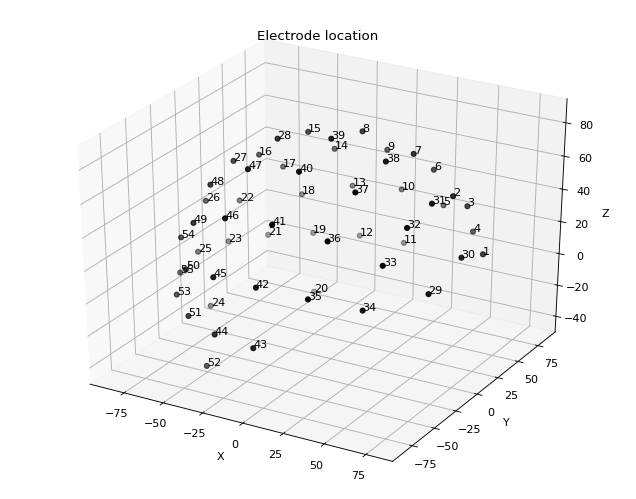

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
chanlocs= mat['EEG'][0][0]['chanlocs']
x=np.empty(0)
y=np.empty(0)
z=np.empty(0)
for channel in chanlocs[0,:]:
  x= np.append(x, channel[4])
x= x.flatten()
for channel in chanlocs[0,:]:
  y= np.append(y, channel[5])
y= y.flatten()
for channel in chanlocs[0,:]:
  z= np.append(z, channel[6])
z= z.flatten()

figure(figsize=(10,8), dpi=80)
ax = plt.axes(projection="3d")
ax.scatter(x, y, z, color= 'k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Electrode location')
for i in range(len(chanlocs[0, :])):
  ax.text3D(x[i],y[i],z[i], i+1)

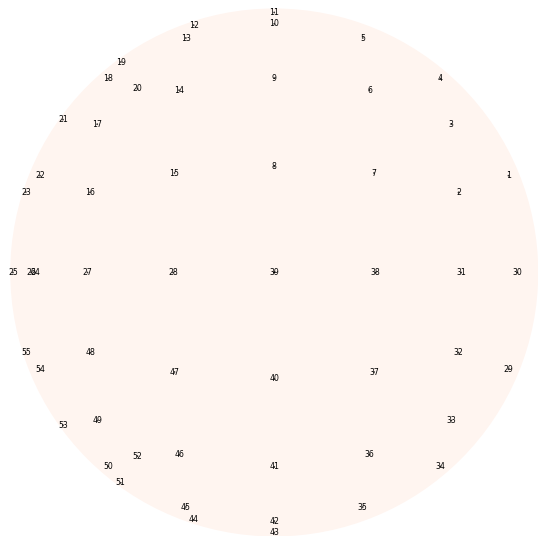

In [ ]:
import mne
chanloc2d = np.vstack((x,y)).T
channumber = np.array(range(len(chanlocs[0, :])))+1
figure(figsize=(10,8), dpi=80)
mne.viz.plot_topomap(np.zeros(mat['EEG'][0][0]['nbchan'][0][0]),chanloc2d, names=channumber,show_names=True )
plt.show() 

**Spectral analysis via FFT**


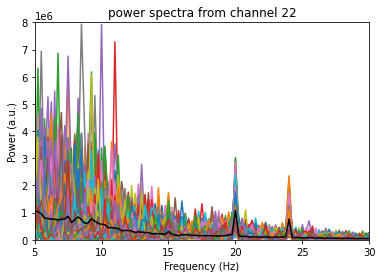

In [ ]:
import scipy
import math
chan2plot= 21
pnts= mat['EEG'][0][0]['pnts'][0][0]
trials= mat['EEG'][0][0]['trials'][0][0]
channelpower = np.zeros([pnts, trials])
data= mat['EEG'][0][0]['data']
samplerate= mat['EEG'][0][0]['srate'][0][0]
#FFT of one channel
for triali in range(trials):
  channelpower[:, triali] = np.abs(scipy.fft.fft(data[chan2plot,:, triali ]))**2
#same result without using a loop
channelpower= np.abs(scipy.fft.fft(data[chan2plot,:,:], axis=0))**2 
hz= np.linspace(0, samplerate/2, math.floor(pnts/2)+1 ) #vector of frequencies

plt.plot(hz, channelpower[0:len(hz),: ])
plt.plot(hz, np.mean(channelpower[0:len(hz),:], axis=1), color='k')
plt.ylim([0,8000000])
plt.xlim([5,30])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (a.u.)')
plt.title('power spectra from channel 22')
plt.show()

**Spectral power from all channels**


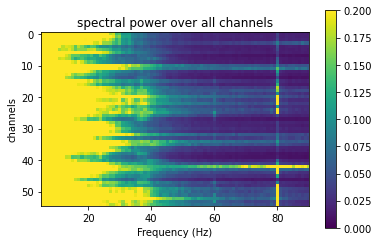

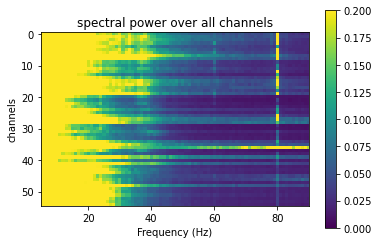

In [ ]:
allchannelpower = np.mean(np.abs(scipy.fft.fft(data, axis=1)/pnts)**2, axis=2) #FFT of all channels at the same time, and then average over all trials.

plt.imshow(allchannelpower[:,0:len(hz)])
plt.xlim([5,90])
plt.clim(0, 0.2)
plt.colorbar()
plt.xlabel('Frequency (Hz)')
plt.ylabel('channels')
plt.title('spectral power over all channels')
plt.show()

sortXidx= [i[0] for i in sorted(enumerate(x), key=lambda x:x[1])] #sort by channel X-coordinate
plt.imshow(allchannelpower[sortXidx,0:len(hz)])
plt.xlim([5,90])
plt.clim(0, 0.2)
plt.colorbar()
plt.xlabel('Frequency (Hz)')
plt.ylabel('channels')
plt.title('spectral power over all channels')
plt.show()

**Topographical maps**

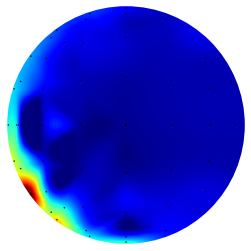

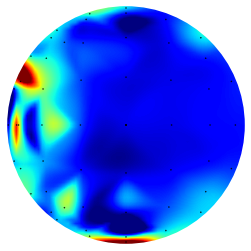

(<matplotlib.image.AxesImage at 0x7ffabe376250>, None)

In [ ]:
#topoplot of 20 and 24 Hz activity
hzidx1= np.where(hz==20)[0][0]
hzidx2= np.where(hz==24)[0][0]
mne.viz.plot_topomap(allchannelpower[:,hzidx1],chanloc2d, cmap='jet', contours=0)
mne.viz.plot_topomap(allchannelpower[:,hzidx2],chanloc2d, cmap='jet', contours=0)

**Endogenous alpha frequency**

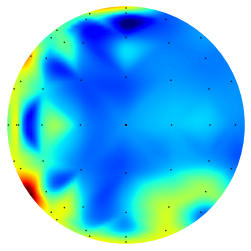

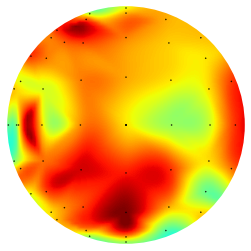

(<matplotlib.image.AxesImage at 0x7ffabd21d610>, None)

In [ ]:
alphaidx = np.where((hz==8) | (hz==12))[0]
mne.viz.plot_topomap(np.mean(allchannelpower[:,alphaidx[0]:alphaidx[1]+1], axis=1),chanloc2d, cmap='jet', contours=0) #topoplot of alpha over all time points

#alpha change from baseline
times= mat['EEG'][0][0]['times'][0]
timeidx = np.where((times==-1000) | (times==0) | (times==1000))[0]
times[1280]
powerPreStim = np.mean(np.abs(scipy.fft.fft(data[:, timeidx[0]:timeidx[1],:],n=pnts, axis=1)/pnts)**2, axis=2)
powerPstStim = np.mean(np.abs(scipy.fft.fft(data[:, timeidx[1]:timeidx[2],:],n=pnts, axis=1)/pnts)**2, axis=2)
alphaPstVsPre = 10*np.log10(np.mean(powerPstStim[:,alphaidx[0]:alphaidx[1]+1], axis=1)/
                                  np.mean(powerPreStim[:,alphaidx[0]:alphaidx[1]+1], axis=1))
mne.viz.plot_topomap(alphaPstVsPre,chanloc2d, cmap='jet', contours=0)

**Correlate alpha with SSVEP**

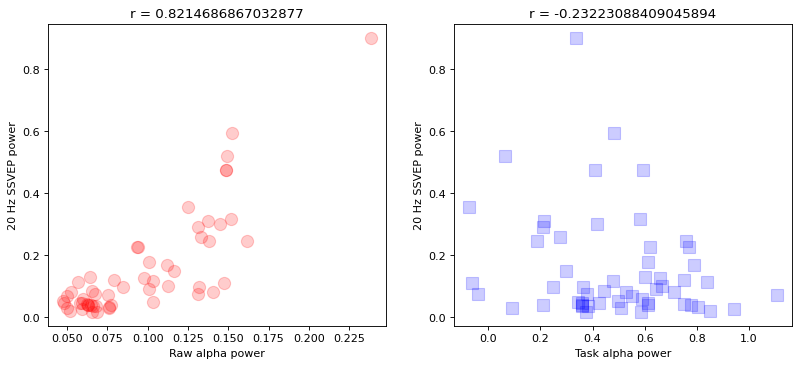

In [ ]:
from numpy.ma.extras import corrcoef
x = np.mean(allchannelpower[:,alphaidx[0]:alphaidx[1]+1], axis=1)
y= allchannelpower[:, hzidx1]

figure(figsize=(12,5), dpi=80)
plt.subplot(121)
plt.scatter(x,y,c='red',marker='o', alpha=0.2, s=120 )
plt.xlabel('Raw alpha power')
plt.ylabel('20 Hz SSVEP power')
r= corrcoef(x,y) #compute pearson correlation
plt.title('r = '+ str(r[0,1]))

plt.subplot(122)
plt.scatter(alphaPstVsPre,y,c='blue',marker='s', alpha=0.2, s=120 )
plt.xlabel('Task alpha power')
plt.ylabel('20 Hz SSVEP power')
r= corrcoef(alphaPstVsPre,y)
plt.title('r = '+ str(r[0,1]))

plt.show()